<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/MINE_0301.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MINE

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
data_size = 20000
cor = [0.5, 1, 1.5, 2.5, 3]

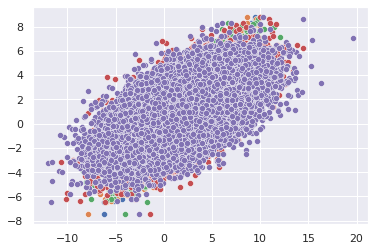

In [24]:
y= np.random.normal(1,2,data_size)
x = np.zeros((data_size,6))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

<AxesSubplot:>

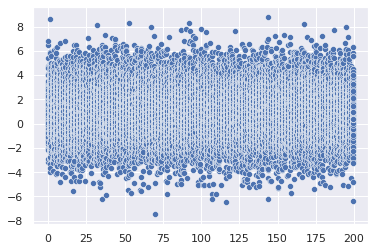

In [26]:
for i in range(200):
    os = i*100
    x[os:os+100,2] = y[os:os+100] + np.random.normal(1,2-(i/100),100)    
    x[os:os+100,4] = y[os:os+100] + np.random.normal(1,1+(i/100),100)
    x[os:os+100,5] = i
sns.scatterplot(x=x[:,5],y=y)

In [27]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [29]:
mi_scores = make_mi_scores(pd.DataFrame(x[:,0:5],columns=['x0','x1','x2','x3','x4']), y, discrete_features="auto")
print(mi_scores)


x0    1.431086
x1    0.813346
x2    0.800763
x4    0.347573
x3    0.246781
Name: MI Scores, dtype: float64


In [30]:
cmi_scores = make_mi_scores(pd.DataFrame(x[:,0:5],columns=['x0','x1','x2','x3','x4']), x[:,5], discrete_features="auto")
print(cmi_scores)

x4    0.027905
x2    0.016657
x0    0.009637
x1    0.004646
x3    0.003351
Name: MI Scores, dtype: float64


In [8]:
for i in range(200):
    os = i*100
    mi_scores = make_mi_scores(pd.DataFrame(x[os:os+100,4],columns=['x4']), y[os:os+100], discrete_features="auto")
    print(i, mi_scores)

0 x4    0.796303
Name: MI Scores, dtype: float64
1 x4    0.975
Name: MI Scores, dtype: float64
2 x4    0.690043
Name: MI Scores, dtype: float64
3 x4    0.746774
Name: MI Scores, dtype: float64
4 x4    0.727982
Name: MI Scores, dtype: float64
5 x4    0.693425
Name: MI Scores, dtype: float64
6 x4    0.672481
Name: MI Scores, dtype: float64
7 x4    0.794349
Name: MI Scores, dtype: float64
8 x4    0.758846
Name: MI Scores, dtype: float64
9 x4    0.870449
Name: MI Scores, dtype: float64
10 x4    0.765878
Name: MI Scores, dtype: float64
11 x4    0.584942
Name: MI Scores, dtype: float64
12 x4    0.768357
Name: MI Scores, dtype: float64
13 x4    0.757858
Name: MI Scores, dtype: float64
14 x4    0.635388
Name: MI Scores, dtype: float64
15 x4    0.554023
Name: MI Scores, dtype: float64
16 x4    0.76462
Name: MI Scores, dtype: float64
17 x4    0.620319
Name: MI Scores, dtype: float64
18 x4    0.71254
Name: MI Scores, dtype: float64
19 x4    0.618961
Name: MI Scores, dtype: float64
20 x4    0.6428

(20000, 6)
(20000, 1)


100%|██████████| 300/300 [00:10<00:00, 29.34it/s]


tensor([ 1.4191e+00,  7.9240e-01,  4.9341e-01,  2.6080e-01,  3.5719e-01,
        -1.1516e-04], grad_fn=<CopySlices>)


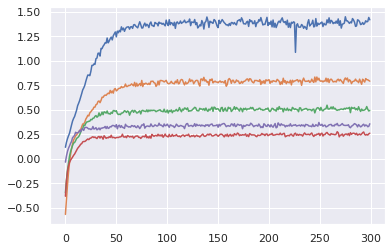

In [9]:
from tqdm import tqdm

H=20
n_epoch = 300
minibatch = 10000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2  

model = [Net() for i in range(x.shape[1])]
optimizer = [torch.optim.Adam(model[i].parameters(), lr=0.01) for i in range(x.shape[1])]

plot_loss = []

y=y.reshape(-1,1)
print(x.shape)
print(y.shape)

for epoch in tqdm(range(n_epoch)):
    back_loss = torch.zeros(6)
    s = np.random.choice(x.shape[0],minibatch)
    for i in range(x.shape[1]):
        x_sample = Variable(torch.from_numpy(x[s,i].reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)    
        ret = torch.mean(model[i](x_sample, y_sample)) - torch.log(torch.mean(torch.exp(model[i](x_sample, y_shuffle))))
        loss = - ret  # maximize
        model[i].zero_grad()
        loss.backward()
        optimizer[i].step()
        back_loss[i] = ret

    plot_loss.append(back_loss.data.numpy())


    #back_loss = loss

print('')
print(back_loss)

plot_loss = np.asarray(plot_loss)

plt.plot(plot_loss[:,0])
plt.plot(plot_loss[:,1])
plt.plot(plot_loss[:,2])
plt.plot(plot_loss[:,3])
plt.plot(plot_loss[:,4])

(20000, 6)
(20000, 1)


100%|██████████| 400/400 [00:26<00:00, 15.19it/s]


Origin: x0    1.431086
x1    0.813346
x2    0.800763
x4    0.347573
x3    0.246781
Name: MI Scores, dtype: float64
MINE: [1.4175477  0.804018   0.78044075 0.24963415 0.33291963]
CMINE: [ 1.1905988e-04 -3.7950237e-04  5.7960567e-03  3.3647615e-05
  1.0793988e-02]


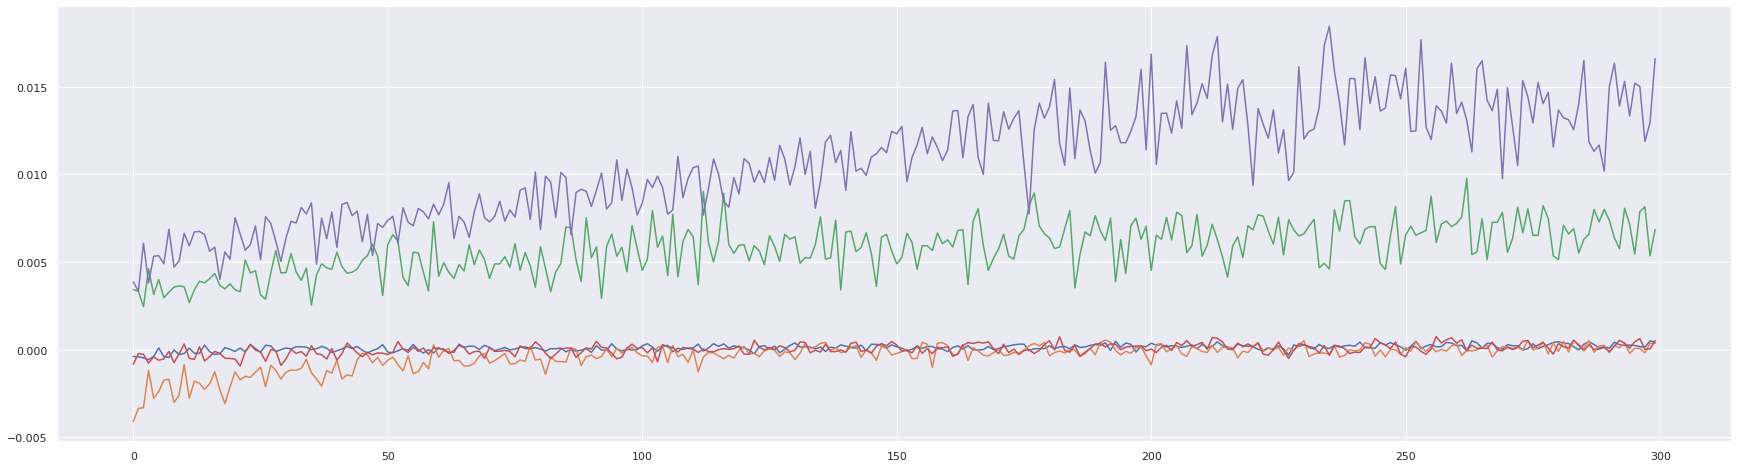

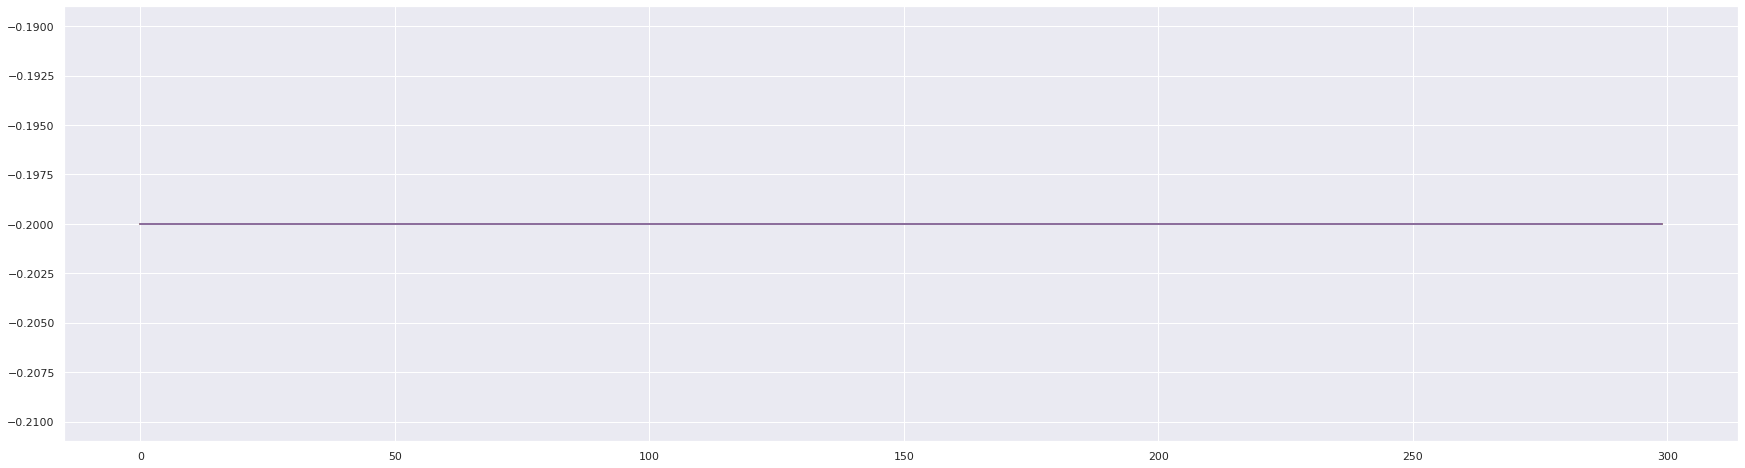

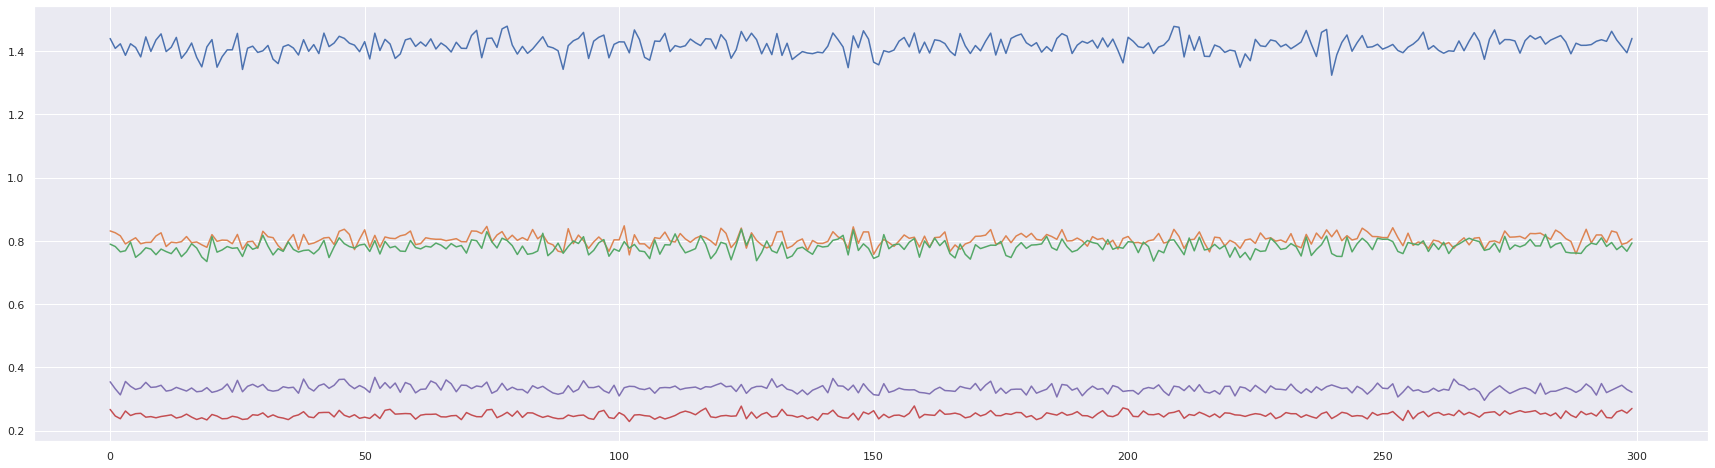

'\nchunk_loss = np.asarray(chunk_loss)\nplt.figure(figsize=(30,8))\nplt.plot(chunk_loss[:,0:4])\nplt.show()\n'

In [72]:
from tqdm import tqdm

H=50
n_epoch = 400
minibatch = 10000

class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()

        self.fc4 = nn.ModuleList()
        self.fc5 = nn.ModuleList()
        self.fc6 = nn.ModuleList()
        
        for i in range(self.input_dim): 
            self.fc1.append(nn.Linear(1, H))
            self.fc2.append(nn.Linear(1, H))
            self.fc3.append(nn.Linear(H, 1))

        for i in range(self.input_dim):
            self.fc4.append(nn.Linear(1, H))
            self.fc5.append(nn.Linear(1, H))
            self.fc6.append(nn.Linear(H, 1))

    def forward(self, x, y, z):
        pxy = []
        pxz = []    
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](x[:,i].reshape(-1,1)) + 
                        self.fc2[i](y))
            h1 = self.fc3[i](h0)
            pxy.append(h1)

        for i in range(self.input_dim):
            h0 = F.relu(self.fc4[i](x[:,i].reshape(-1,1)) + 
                        self.fc5[i](z))
            h1 = self.fc6[i](h0)
            pxz.append(h1)
            
        return torch.cat(pxy, dim=1),torch.cat(pxz, dim=1)  

model = Net(x.shape[1]-1) # -1 은 t차원을 제외한 것...
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

plot_loss = []
chunk_loss = []
di = []
dt = []
y=y.reshape(-1,1)
print(x.shape)
print(y.shape)

chunk_size = 1000
T = int(x.shape[0]/chunk_size)
'''
for chunk in tqdm(range(T)):
    #chunk = np.random.choice(range(T))
    for epoch in range(30):
'''
if 1 == 1 :
    for epoch in tqdm(range(n_epoch)):

        s = np.sort(np.random.choice(x.shape[0],minibatch, replace=False))
        #print(s)
        #s = [*range(chunk*chunk_size,chunk*chunk_size+chunk_size)]
        #s = np.random.choice(s,chunk_size)
        x_sample = Variable(torch.from_numpy(x[s,0:5]).type(torch.FloatTensor), requires_grad = True)
        t_sample = Variable(torch.from_numpy(x[s,5].reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)

        y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)   
        t_shuffle = Variable(torch.from_numpy(np.random.permutation(x[s,5].reshape(-1,1))).type(torch.FloatTensor), requires_grad = True)   
         
        p_xy,p_xz = model(x_sample, y_sample, t_sample)
        p_x_y,p_x_z = model(x_sample, y_shuffle, t_shuffle)        

        ret1 = torch.mean(p_xy,0) - torch.log(torch.mean(torch.exp(p_x_y),0))
        ret2 = torch.mean(p_xz,0) - torch.log(torch.mean(torch.exp(p_x_z),0))
        
        loss = - (ret1 + ret2)  # maximize
        #ret2.requires_grad_(True)
        #ret2.retain_grad()
        model.zero_grad()
        
        #t_sample.retain_grad()
        loss.mean().backward()
        optimizer.step()

        plot_loss.append((ret1-ret2).data.numpy())

        #print(torch.mean(p_xy[:,4]))
        #dx = torch.autograd.grad(ret2[4], t_sample)
        #print(ret2.grad)
        dt.append(ret2.grad.data.numpy())
        di.append(ret2.data.numpy())
        #back_loss = loss
        #if i == 99:
        #    print(loss[4])
    #chunk_loss.append(-loss.data.numpy())

#print(torch.mean(x_sample.grad,0))

plot_loss = np.asarray(plot_loss)
df_loss = pd.DataFrame(plot_loss,columns=['x0','x1','x2','x3','x4'])
#df_loss.rolling(window=5).mean().plot()

di = np.asarray(di)
#print(mi_scores)

print("Origin:",mi_scores)

print("MINE:",np.mean(plot_loss[100:,:],0))
print("CMINE:",np.mean(di[100:,:],0))

plt.figure(figsize=(30,8))
plt.plot(di[100:])
plt.show()
#print(np.mean(di[200:,0],0))
plt.figure(figsize=(30,8))
plt.plot(dt[100:])
plt.show()
#print(x_sample.grad)
plt.figure(figsize=(30,8))
plt.plot(plot_loss[100:,0:5])
plt.show()
'''
chunk_loss = np.asarray(chunk_loss)
plt.figure(figsize=(30,8))
plt.plot(chunk_loss[:,0:4])
plt.show()
'''

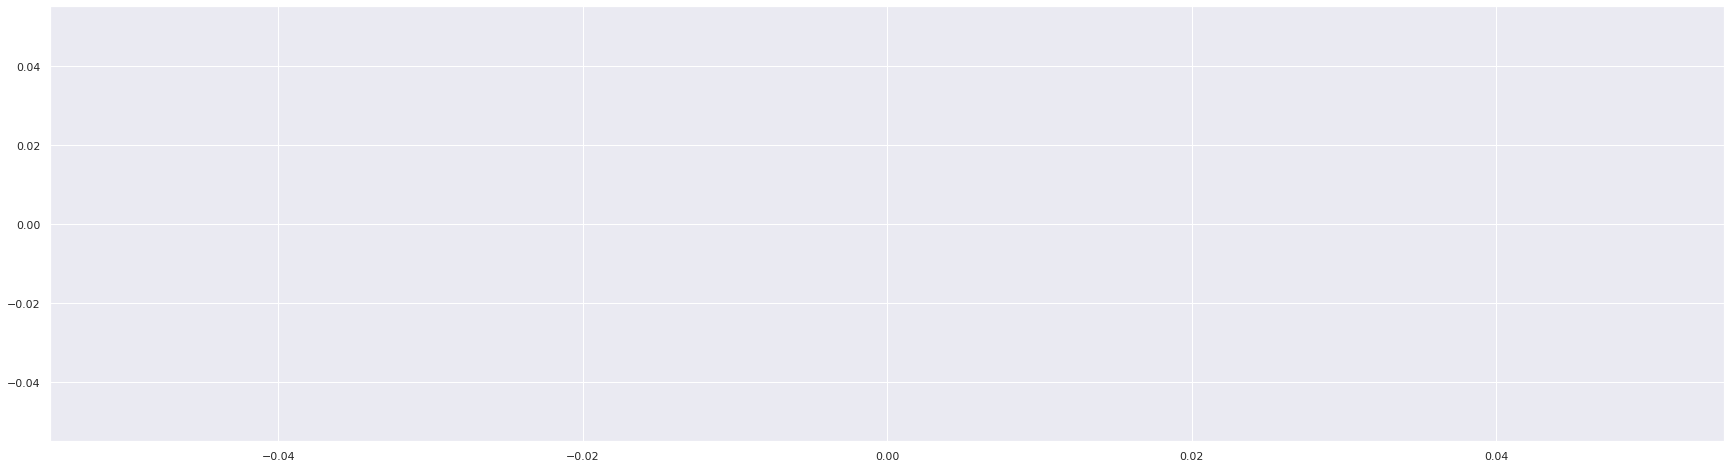

In [11]:
plt.figure(figsize=(30,8))
plt.plot(di[1000:])
plt.show()

In [12]:
print(torch.mean(model.fc2[0].weight))
print(torch.mean(model.fc2[1].weight))
print(torch.mean(model.fc2[2].weight))
print(torch.mean(model.fc2[3].weight))
print(torch.mean(model.fc2[4].weight))

tensor(0.0455, grad_fn=<MeanBackward0>)
tensor(-0.0544, grad_fn=<MeanBackward0>)
tensor(0.1726, grad_fn=<MeanBackward0>)
tensor(0.1033, grad_fn=<MeanBackward0>)
tensor(-0.0230, grad_fn=<MeanBackward0>)


In [13]:
print(torch.sum(model.fc2[0].weight))
print(torch.sum(model.fc2[1].weight))
print(torch.sum(model.fc2[2].weight))
print(torch.sum(model.fc2[3].weight))
print(torch.sum(model.fc2[4].weight))

tensor(2.2768, grad_fn=<SumBackward0>)
tensor(-2.7201, grad_fn=<SumBackward0>)
tensor(8.6311, grad_fn=<SumBackward0>)
tensor(5.1629, grad_fn=<SumBackward0>)
tensor(-1.1479, grad_fn=<SumBackward0>)


In [14]:
x_sample = Variable(torch.from_numpy(x[:,0:5]).type(torch.FloatTensor), requires_grad = True)
t_sample = Variable(torch.from_numpy(x[:,5].reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
y_sample = Variable(torch.from_numpy(y[:]).type(torch.FloatTensor), requires_grad = True)
y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[:])).type(torch.FloatTensor), requires_grad = True)    
p_xy = model(x_sample, t_sample, y_sample)
p_x_y = model(x_sample, t_sample, y_shuffle)
ret = torch.mean(p_xy,0) - torch.log(torch.mean(torch.exp(p_x_y),0))
loss = - ret  # maximize
print(loss)
dx4 = torch.autograd.grad(loss[4], t_sample)[0]

print(torch.mean(dx4))


TypeError: ignored

In [ ]:
plot_loss = np.asarray(plot_loss)
df_loss = pd.DataFrame(plot_loss,columns=['x0','x1','x2','x3','x4'])
df_sloss = df_loss.rolling(window=30).mean()
df_sloss.plot(figsize=(30,8))

print(np.mean(np.gradient(df_sloss[200:]['x0'].values)))
print(np.mean(np.gradient(df_sloss[200:]['x1'].values)))
print(np.mean(np.gradient(df_sloss[200:]['x2'].values)))
print(np.mean(np.gradient(df_sloss[200:]['x3'].values)))
print(np.mean(np.gradient(df_sloss[200:]['x4'].values)))

In [ ]:
df_sloss

In [ ]:
print(np.mean(di[200:,:],0))
plt.figure(figsize=(30,8))
plt.plot(di[:,4])
plt.show()

In [ ]:
di

+ 편미분 Test

In [ ]:
def uc(a,b):
    return a*b[0] + b[1]

In [ ]:
x = torch.tensor(100.0, requires_grad=True)
t = torch.tensor(2.0, requires_grad=True)
print(x)
print(t)
u = x**2 * t
print(u)
# 1st derivatives
#dt = torch.autograd.grad(u, t)[0]
#print(dt)
dx = torch.autograd.grad(u, x,create_graph=True)[0]
print(dx)
# 2nd derivatives (higher orders require `create_graph=True`)
ddx = torch.autograd.grad(dx, x)[0]
print(ddx)

In [ ]:
tx = torch.tensor([*range(200)],dtype=float, requires_grad=True)
ty = tx * torch.normal(1.0,0.5,size=(200,))
dx = torch.autograd.grad(torch.sum(ty), tx)[0]
print(np.mean(dx.tolist()))

In [ ]:
plt.plot(ty.detach().numpy(),'.')

In [ ]:
a = torch.rand(10, requires_grad=True)
b = torch.rand(10, requires_grad=True)

output = (2 * a).sum()

c = torch.autograd.grad(output, (a, b),allow_unused=True)
c

In [ ]:
aa = np.random.rand(3,3)
aa

In [ ]:
aa[:,[1,-1]]